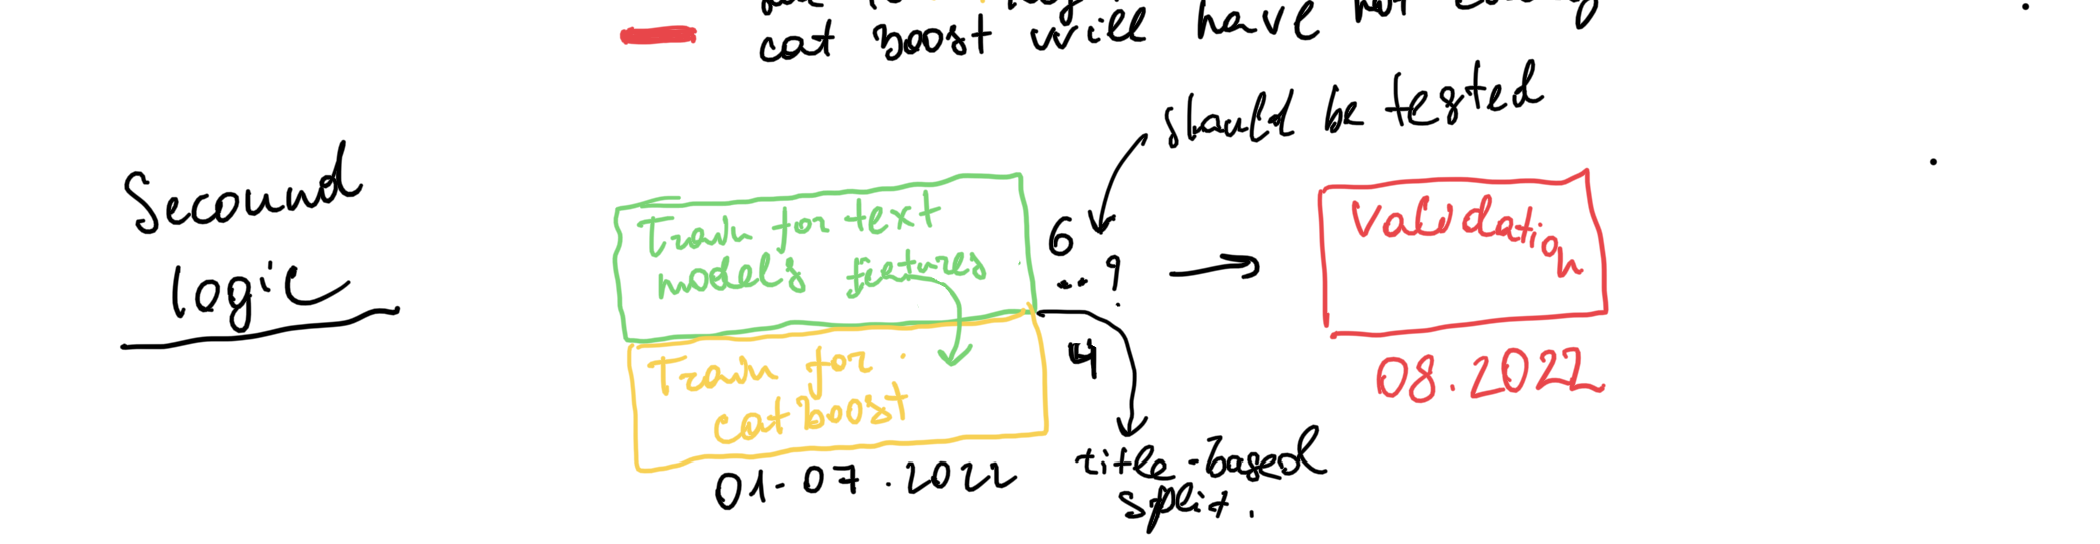

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import requests
import ast
import geoip2.database

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from catboost import CatBoostClassifier, Pool
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from transformers import AutoTokenizer, BertForSequenceClassification
from transformers import pipeline
import gc

from scipy.special import softmax

# loading data

cc_codes = ["uk", "de", "pl", "es", "ru", "en"]
filename_pattern_train = "data/multilingual_train/processed_train_{}.csv".format("_".join(cc_codes))
filename_pattern_test = "data/multilingual_train/processed_test_{}.csv".format("_".join(cc_codes))

train_df = pd.read_csv(filename_pattern_train)
test_df = pd.read_csv(filename_pattern_test)

train_df = train_df[train_df["is_text_train"] == 0]

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Features preparation: 

In [12]:
features_list = [
       'wiki_db',
       # 'page_title', 
       # 'page_revision_count', 
       'revision_text_bytes_diff',
       'is_mobile_edit', 'is_mobile_web_edit',
       'is_visualeditor', 'is_wikieditor',
       'is_mobile_app_editandroid_app_edit', 'is_ios_app_edit',
       # 'texts_removed', 'texts_insert', 'texts_change', 'actions',
       # 'categories', 'wikidata_item_id', 
       # 'page_region', 'country_iso_code',
       # 'region_iso_code', 'city', 'latitude', 'longitude',
       'Argument_change', 'Argument_insert', 'Argument_move', 'Argument_remove', 'Category_change', 
    'Category_insert', 'Category_move', 'Category_remove', 'Comment_change', 'Comment_insert', 
    'Comment_move', 'Comment_remove', 'ExternalLink_change', 'ExternalLink_insert', 'ExternalLink_move', 
    'ExternalLink_remove', 'Gallery_change', 'Gallery_insert', 'Gallery_move', 'Gallery_remove', 'HTMLEntity_change', 
    'HTMLEntity_insert', 'HTMLEntity_move', 'HTMLEntity_remove', 'Heading_change', 'Heading_insert', 'Heading_move',
    'Heading_remove', 'List_change', 'List_insert', 'List_move', 'List_remove', 'Media_change', 'Media_insert',
    'Media_move', 'Media_remove', 'Paragraph_change', 'Paragraph_insert', 'Paragraph_move', 'Paragraph_remove', 
    'Punctuation_change', 'Punctuation_insert', 'Punctuation_move', 'Punctuation_remove', 'Reference_change',
    'Reference_insert', 'Reference_move', 'Reference_remove', 'Section_change', 'Section_insert', 'Section_move',
    'Section_remove', 'Sentence_change', 'Sentence_insert', 'Sentence_move', 'Sentence_remove', 'Table_change',
    'Table_insert', 'Table_move', 'Table_remove', 'Table Element_change', 'Table Element_insert', 'Table Element_move',
    'Table Element_remove', 'Template_change', 'Template_insert', 'Template_move', 'Template_remove', 'Text_change',
    'Text_insert', 'Text_move', 'Text_remove', 'Text Formatting_change', 'Text Formatting_insert', 'Text Formatting_move',
    'Text Formatting_remove', 'Whitespace_change', 'Whitespace_insert', 'Whitespace_move', 'Whitespace_remove', 
    'Wikilink_change', 'Wikilink_insert', 'Wikilink_move', 'Wikilink_remove', 'Word_change', 'Word_insert',
    'Word_move', 'Word_remove'
] \
+ [f"insert_{c}" for c in ["s_0_max", "s_1_max", "p_0_max", "p_1_max", "s_0_mean", "s_1_mean", "p_0_mean", "p_1_mean"]] \
+ [f"change_{c}" for c in ["s_0_max", "s_1_max", "p_0_max", "p_1_max", "s_0_mean", "s_1_mean", "p_0_mean", "p_1_mean"]] \
+ [f"comment_{c}" for c in ["s_0", "s_1", "p_0", "p_1"]] \
+ [f"title_{c}" for c in ["s_0", "p_0"]]

# Modeling:

In [13]:
BALANCE_DATASET = False
BALANCE_CLASS_MODEL = True

is_text_train_filter = 'is_text_train'
balancing_column = 'is_balanced'
target_column = 'revision_is_identity_reverted'
features = features_list

X_train, X_test, y_train, y_test = train_test_split(train_df[features].fillna(-1), 
                                                    train_df[target_column], 
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    stratify=train_df[target_column])


cat_features = [
    'wiki_db',
    # 'page_title', 
    'is_mobile_edit', 'is_mobile_web_edit',
    'is_visualeditor', 'is_wikieditor',
    'is_mobile_app_editandroid_app_edit', 'is_ios_app_edit',
    # 'page_region', 'country_iso_code',
    # 'region_iso_code', 'city'
]

train_data = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features
)
test_data = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_features
)

### class weighting
if BALANCE_CLASS_MODEL:
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weights = dict(zip(classes, weights))
else:
    class_weights = {0: 1, 1: 1}
#####


# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=5000, metric_period=100, verbose=True, learning_rate=0.01, class_weights=class_weights,
                           custom_metric=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'])
# Fit model
model.fit(train_data, eval_set=test_data, plot=False)

# baseline score -> not training :)
model.best_score_

0:	learn: 0.6906799	test: 0.6906492	best: 0.6906492 (0)	total: 207ms	remaining: 17m 16s
100:	learn: 0.5837961	test: 0.5820622	best: 0.5820622 (100)	total: 13.2s	remaining: 10m 42s
200:	learn: 0.5587174	test: 0.5563312	best: 0.5563312 (200)	total: 25.9s	remaining: 10m 18s
300:	learn: 0.5480575	test: 0.5454061	best: 0.5454061 (300)	total: 38.4s	remaining: 9m 59s
400:	learn: 0.5421339	test: 0.5392838	best: 0.5392838 (400)	total: 51.1s	remaining: 9m 45s
500:	learn: 0.5383910	test: 0.5353535	best: 0.5353535 (500)	total: 1m 3s	remaining: 9m 32s
600:	learn: 0.5356527	test: 0.5324962	best: 0.5324962 (600)	total: 1m 16s	remaining: 9m 19s
700:	learn: 0.5336256	test: 0.5304033	best: 0.5304033 (700)	total: 1m 29s	remaining: 9m 6s
800:	learn: 0.5320419	test: 0.5288036	best: 0.5288036 (800)	total: 1m 41s	remaining: 8m 53s
900:	learn: 0.5306809	test: 0.5274459	best: 0.5274459 (900)	total: 1m 54s	remaining: 8m 40s
1000:	learn: 0.5295051	test: 0.5262762	best: 0.5262762 (1000)	total: 2m 6s	remaining: 8m

{'learn': {'Accuracy:use_weights=false': 0.7442019930847706,
  'Precision:use_weights=false': 0.7227615233181726,
  'Recall:use_weights=false': 0.7140205654285001,
  'Logloss:use_weights=true': 0.5116187492503381,
  'Accuracy:use_weights=true': 0.7415463007152809,
  'Logloss:use_weights=false': 0.5106012173052719,
  'Logloss': 0.5116187492503381,
  'Precision:use_weights=true': 0.7598329784393852,
  'Recall:use_weights=true': 0.7140205654285001,
  'F1:use_weights=false': 0.7160732599549393,
  'F1:use_weights=true': 0.7342308046769032},
 'validation': {'Accuracy:use_weights=false': 0.7442747466810719,
  'Recall:use_weights=false': 0.7173968184947639,
  'Precision:use_weights=false': 0.7270470301667603,
  'Logloss:use_weights=true': 0.5118887134676289,
  'Accuracy:use_weights=true': 0.7419097757749532,
  'AUC': 0.822824086774067,
  'Logloss:use_weights=false': 0.5109746886087441,
  'Logloss': 0.5118887134676289,
  'Precision:use_weights=true': 0.7637327662764168,
  'Recall:use_weights=tr

In [14]:
class_weights

{0: 0.9120090371338617, 1: 1.1067828068508483}

,count,mean,std,min,25%,50%,75%,max
revision_is_identity_reverted,,,,,,,,
0,33492.0,0.348400,0.205820,0.003722,0.183916,0.311540,0.485062,0.993818
1,27597.0,0.653382,0.242716,0.026688,0.467665,0.677895,0.870931,0.999829


<AxesSubplot:title={'center':'prediction_score'}, xlabel='revision_is_identity_reverted'>

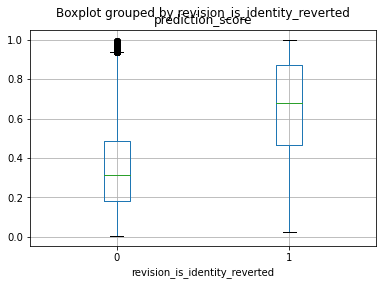

In [15]:
test = pd.DataFrame({
                       "prediction_score": model.predict_proba(test_data)[:, 1],
                       "revision_is_identity_reverted": y_test
                      })
display(test.groupby("revision_is_identity_reverted")["prediction_score"].describe())
test.boxplot(column="prediction_score", by="revision_is_identity_reverted")

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


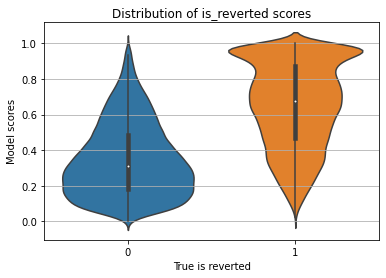

In [16]:
fig, axes = plt.subplots()
sns.violinplot('revision_is_identity_reverted', "prediction_score", data=test, ax = axes)
axes.set_title('Distribution of is_reverted scores')

axes.yaxis.grid(True)
axes.set_xlabel('True is reverted')
axes.set_ylabel('Model scores')

plt.show()

In [17]:
pd.DataFrame({'feature_importance': model.get_feature_importance(train_data), 
              'feature_names': X_test.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

,feature_importance,feature_names
1,8.412978,revision_text_bytes_diff
0,7.983376,wiki_db
101,5.880292,insert_s_1_mean
116,5.412263,title_s_0
105,5.038188,change_s_1_max
...,...,...
71,0.000000,Table Element_remove
94,0.000000,Word_move
76,0.000000,Text_change
79,0.000000,Text_remove


# Hold-out validation

- actions features 0.6823 ->  0.7091 (baseline)


In [18]:
hold_out_data = Pool(
    data=test_df[features].fillna(-1),
    label=test_df[target_column],
    cat_features=cat_features
)

In [19]:
res = model.eval_metrics(hold_out_data, metrics=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'], eval_period=1000)
metrics_holdout = {c: res[c][-1] for c in ['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy']}
metrics_holdout

{'Logloss': 0.5354581904107576,
 'AUC': 0.8005378266191936,
 'Precision': 0.6797120335569965,
 'Recall': 0.6876056497816099,
 'F1': 0.6836360564827072,
 'Accuracy': 0.7280665774399259}

,count,mean,std,min,25%,50%,75%,max
revision_is_identity_reverted,,,,,,,,
0,143370.0,0.352826,0.207892,0.002729,0.185812,0.315149,0.492054,0.997440
1,88145.0,0.626824,0.239049,0.004493,0.440406,0.650179,0.824261,0.999912


<AxesSubplot:title={'center':'prediction_score'}, xlabel='revision_is_identity_reverted'>

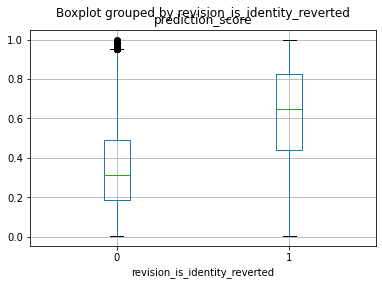

In [20]:
test = pd.DataFrame({
                       "prediction_score": model.predict_proba(hold_out_data)[:, 1],
                       "revision_is_identity_reverted": test_df[target_column]
                      })
display(test.groupby("revision_is_identity_reverted")["prediction_score"].describe())
test.boxplot(column="prediction_score", by="revision_is_identity_reverted")

/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


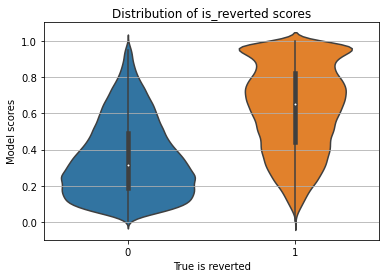

In [21]:
fig, axes = plt.subplots()
sns.violinplot('revision_is_identity_reverted', "prediction_score", data=test, ax = axes)
axes.set_title('Distribution of is_reverted scores')

axes.yaxis.grid(True)
axes.set_xlabel('True is reverted')
axes.set_ylabel('Model scores')

plt.show()

In [22]:
pd.DataFrame({'feature_importance': model.get_feature_importance(hold_out_data), 
              'feature_names': X_test.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False).head(30)

,feature_importance,feature_names
0,8.999206,wiki_db
1,7.542116,revision_text_bytes_diff
116,5.973706,title_s_0
101,5.121520,insert_s_1_mean
105,4.160964,change_s_1_max
108,3.724521,change_s_0_mean
103,3.404551,insert_p_1_mean
107,3.309219,change_p_1_max
5,3.183110,is_wikieditor
89,3.010383,Wikilink_insert


# Balanced hold-out

In [23]:
hold_out_data = Pool(
    data=test_df[test_df.is_balanced == 1][features].fillna(-1),
    label=test_df[test_df.is_balanced == 1][target_column],
    cat_features=cat_features
)
res = model.eval_metrics(hold_out_data, metrics=['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy'], eval_period=1000)
metrics_holdout = {c: res[c][-1] for c in ['Logloss', 'AUC', 'Precision', 'Recall', 'F1', 'Accuracy']}
metrics_holdout

{'Logloss': 0.5722770690275286,
 'AUC': 0.7681131340058791,
 'Precision': 0.7418954514925955,
 'Recall': 0.6876056497816099,
 'F1': 0.7137196376258462,
 'Accuracy': 0.6975843937218689}

,count,mean,std,min,25%,50%,75%,max
revision_is_identity_reverted,,,,,,,,
0,88145.0,0.391276,0.203898,0.002833,0.232627,0.359704,0.533105,0.997440
1,88145.0,0.626824,0.239049,0.004493,0.440406,0.650179,0.824261,0.999912


/home/trokhymovych/.conda/envs/2022-08-18T15.21.49_trokhymovych/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


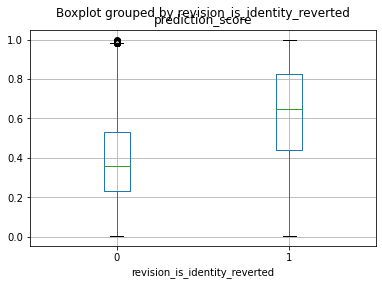

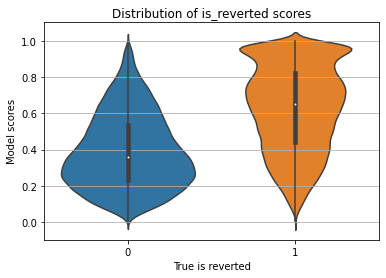

In [24]:
test = pd.DataFrame({
                       "prediction_score": model.predict_proba(hold_out_data)[:, 1],
                       "revision_is_identity_reverted": test_df[test_df.is_balanced == 1][target_column]
                      })
display(test.groupby("revision_is_identity_reverted")["prediction_score"].describe())
test.boxplot(column="prediction_score", by="revision_is_identity_reverted")

fig, axes = plt.subplots()
sns.violinplot('revision_is_identity_reverted', "prediction_score", data=test, ax = axes)
axes.set_title('Distribution of is_reverted scores')

axes.yaxis.grid(True)
axes.set_xlabel('True is reverted')
axes.set_ylabel('Model scores')

plt.show()

In [25]:
model.save_model('classifier') 